In [1]:
using Printf
using Random
using Statistics
using LinearAlgebra

using Flux
using DifferentialEquations
using DiffEqFlux

using JLD2
using BSON
using Plots

using Flux: @epochs

In [2]:
#####
##### Load data from JLD2 file
#####

file = jldopen("../data/ocean_convection_profiles.jld2")

Is = keys(file["timeseries/t"])

Nz = file["grid/Nz"]
Lz = file["grid/Lz"]
Nt = length(Is)

t = zeros(Nt)
T = T_data = zeros(Nt, Nz)
wT = zeros(Nt, Nz)

for (i, I) in enumerate(Is)
    t[i] = file["timeseries/t/$I"]
    T[i, :] = file["timeseries/T/$I"][1, 1, 2:Nz+1]
    wT[i, :] = file["timeseries/wT/$I"][1, 1, 2:Nz+1]
end

In [3]:
#####
##### Plot animation of T(z,t) from data
#####

z = file["grid/zC"]

anim = @animate for n=1:10:Nt
    t_str = @sprintf("%.2f", t[n] / 86400)
    plot(T[n, :], z, linewidth=2,
         xlim=(19, 20), ylim=(-100, 0), label="",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title="Deepening mixed layer: $t_str days", show=false)
end

gif(anim, "deepening_mixed_layer.gif", fps=15)

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer.gif")

In [4]:
#####
##### Coarse grain data to 32 vertical levels (plus halo regions)
#####

function coarse_grain(data, resolution)
    @assert length(data) % resolution == 0
    s = length(data) / resolution
    
    data_cs = zeros(resolution)
    for i in 1:resolution
        t = data[Int((i-1)*s+1):Int(i*s)]
        data_cs[i] = mean(t)
    end
    
    return data_cs
end

coarse_grain (generic function with 1 method)

In [5]:
coarse_resolution = cr = 32

T_cs = zeros(coarse_resolution+2, Nt)
wT_cs = zeros(coarse_resolution+2, Nt)

z_cs = coarse_grain(collect(z), cr)

for n=1:Nt
    T_cs[2:end-1, n] .= coarse_grain(T[n, :], coarse_resolution)
    wT_cs[2:end-1, n] .= coarse_grain(wT[n, :], coarse_resolution)
end

# Fill halo regions to enforce boundary conditions.
T_cs[1,   :] .= T_cs[2,     :]
T_cs[end, :] .= T_cs[end-1, :]

wT_cs[1,   :] .= wT_cs[2,     :]
wT_cs[end, :] .= wT_cs[end-1, :]

1153-element view(::Array{Float64,2}, 34, :) with eltype Float64:
 0.0                   
 1.5331125365696972e-20
 7.911271354005603e-16 
 1.2304105297164787e-9 
 4.5974122132098574e-5 
 1.0547055085790515e-5 
 8.137060758770855e-6  
 1.2038622293350195e-5 
 1.4907061128229536e-5 
 1.5792767216320938e-5 
 1.530926428968028e-5  
 1.5253301156277067e-5 
 1.5900114268351766e-5 
 ⋮                     
 2.2844902222751546e-5 
 2.2763403839288838e-5 
 2.3231222244053888e-5 
 2.3222650347426976e-5 
 2.283412754729221e-5  
 2.3338021569767357e-5 
 2.373534240067239e-5  
 2.294745382948997e-5  
 2.2675479202722983e-5 
 2.3958085984339186e-5 
 2.321076064839628e-5  
 2.335174325015586e-5  

In [7]:
#####
##### Plot coarse temperature and wT profiles
#####

@info "Plotting coarse temperature profile..."

anim = @animate for n=1:10:Nt
    t_str = @sprintf("%.2f", t[n] / 86400)
    plot(T_cs[2:cr+1, n], z_cs, linewidth=2,
         xlim=(19, 20), ylim=(-100, 0), label="",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title="Deepening mixed layer: $t_str days", show=false)
end

gif_T = gif(anim, "deepening_mixed_layer_T_coarse.gif", fps=15)

display(gif_T)

@info "Plotting coarse wT profile..."

anim = @animate for n=1:10:Nt
    t_str = @sprintf("%.2f", t[n] / 86400)
    plot(wT_cs[2:cr+1, n], z_cs, linewidth=2,
         xlim=(-1e-4, 1e-4), ylim=(-100, 0), label="",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title="Deepening mixed layer: $t_str days", show=false)
end

gif_wT = gif(anim, "deepening_mixed_layer_wT_coarse.gif", fps=15)

display(gif_wT)

┌ Info: Plotting coarse temperature profile...
└ @ Main In[7]:5


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_T_coarse.gif")

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_T_coarse.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95
┌ Info: Plotting coarse wT profile...
└ @ Main In[7]:19


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_wT_coarse.gif")

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_wT_coarse.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


In [8]:
#####
##### Generate differentiation matrices
#####

cr_Δz = Lz / cr  # Coarse resolution Δz

# Dzᶠ computes the derivative from cell center to cell (F)aces
Dzᶠ = 1/cr_Δz * Tridiagonal(-ones(cr+1), ones(cr+2), zeros(cr+1))

# Dzᶜ computes the derivative from cell faces to cell (C)enters
Dzᶜ = 1/cr_Δz * Tridiagonal(zeros(cr+1), -ones(cr+2), ones(cr+1))

34×34 Tridiagonal{Float64,Array{Float64,1}}:
 -0.32   0.32    ⋅      ⋅      ⋅    …    ⋅      ⋅      ⋅      ⋅      ⋅  
  0.0   -0.32   0.32    ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅     0.0   -0.32   0.32    ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅     0.0   -0.32   0.32       ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅     0.0   -0.32       ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅     0.0   …    ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅    …    ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
  ⋮   

In [103]:
#####
##### Create training data
#####

Tₙ    = zeros(cr+2, Nt-1)
Tₙ₊₁  = zeros(cr+2, Nt-1)
wTₙ   = zeros(cr+2, Nt-1)
∂zTₙ  = zeros(cr+2, Nt-1)
∂zwTₙ = zeros(cr+2, Nt-1)

for i in 1:Nt-1
       Tₙ[:, i] .=  T_cs[:,   i]
     Tₙ₊₁[:, i] .=  T_cs[:, i+1]
      wTₙ[:, i] .= wT_cs[:,   i]
     ∂zTₙ[:, i] .= Dzᶠ * T_cs[:, i]
    ∂zwTₙ[:, i] .= Dzᶜ * wT_cs[:, i]
end

N_skip = 100  # Skip first N_skip iterations to avoid learning transients.
N = 32  # Number of training data pairs.

pre_training_data = [(Tₙ[:, i], -wTₙ[:, i]) for i in N_skip:N+N_skip]

training_data = [(Tₙ[:, i], Tₙ₊₁[:, i]) for i in N_skip:N+N_skip];

In [144]:
#####
##### Create heat flux vector
#####

heat_flux = zeros(cr+2)

Q  = -100
ρ₀ = file["parameters/density"]
cₚ = file["parameters/specific_heat_capacity"]

heat_flux[cr+1] = Q / (ρ₀ * cₚ * cr_Δz)

-7.789678675754626e-6

In [105]:
#####
##### Create neural network
#####

# Complete black box right-hand-side.
# dTdt_NN = Chain(Dense(cr+2,  2cr, tanh),
#                 Dense(2cr,  cr+2))

# Use NN to parameterize a diffusivity or κ profile.
# dTdt_NN = Chain(T -> Dzᶠ*T,
#                 Dense(cr+2,  2cr, tanh),
#                 Dense(2cr,  cr+2),
#                 NNDzT -> Dzᶜ * NNDzT + heat_flux)

# Use NN to parameterize the horizontally averaged buoyancy flux (wT).
dTdt_NN = Chain(T -> Dzᶠ*T,
                Dense(cr+2, 4cr, relu),
                Dense(4cr,  4cr, relu),
                Dense(4cr,  cr+2))

NN_params = Flux.params(dTdt_NN);

In [123]:
#####
##### Pre-train the neural network on (T, wT) data pairs
#####

pre_loss_function(Tₙ, wTₙ) = sum(abs2, dTdt_NN(Tₙ) .- wTₙ) ./ sum(abs2, wTₙ)

popt = ADAM(0.01)

function precb()
    loss = sum([pre_loss_function(pre_training_data[i]...) for i in 1:N])
    println("loss = $loss")
    loss < 100 && Flux.stop()
    return loss
end

precb()

loss = 298.95585822160626 (tracked)


298.95585822160626 (tracked)

In [124]:
popt.eta = 0.001

pre_train_epochs = 50
for _ in 1:pre_train_epochs
    Flux.train!(pre_loss_function, NN_params, pre_training_data, popt, cb = Flux.throttle(precb, 5))
end

loss = 704786.769488876 (tracked)
loss = 12008.150872636932 (tracked)
loss = 91.08645664759673 (tracked)
loss = 279.7108532402639 (tracked)
loss = 15.642659964705608 (tracked)
loss = 4.651225612250451 (tracked)
loss = 4.428038217584587 (tracked)
loss = 11.940727907105456 (tracked)
loss = 12.340626755139628 (tracked)
loss = 5.434068195928349 (tracked)
loss = 3.017631750360685 (tracked)
loss = 6.938946926646773 (tracked)
loss = 8.033413253926755 (tracked)
loss = 3.7889963146819388 (tracked)
loss = 1.4675837635566782 (tracked)
loss = 4.018305365589425 (tracked)
loss = 5.809092165642237 (tracked)
loss = 3.6628441648613856 (tracked)
loss = 1.6294598652425327 (tracked)
loss = 2.588511396194103 (tracked)
loss = 3.593771911217734 (tracked)
loss = 2.2296102490984486 (tracked)
loss = 0.8294679690594288 (tracked)
loss = 1.5630159448940173 (tracked)
loss = 2.637805176101422 (tracked)
loss = 2.0710445580079093 (tracked)
loss = 1.0667862847014733 (tracked)
loss = 1.213149992133531 (tracked)
loss = 1

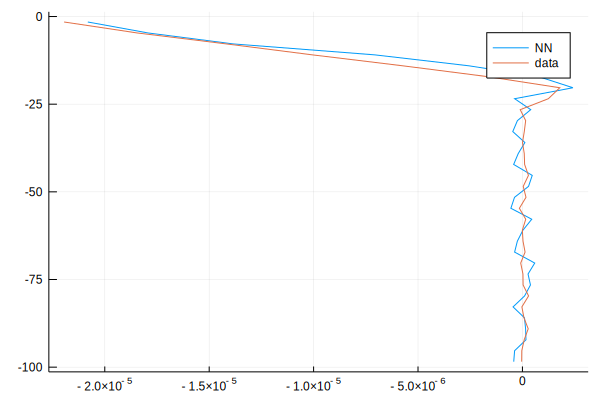

In [130]:
z_cs = coarse_grain(z, cr)

n = 32

wT = dTdt_NN(pre_training_data[n][1]) |> Flux.data

plot(wT[2:cr+1], z_cs, label="NN")
plot!(pre_training_data[n][2][2:cr+1], z_cs, label="data")

In [ ]:
#####
##### Define loss function
#####

tspan = (0.0, 600.0)  # 10 minutes
neural_pde_prediction(T₀) = neural_ode(dTdt_NN, T₀, tspan, Tsit5(), reltol=1e-4, save_start=false, saveat=tspan[2])

loss_function(Tₙ, Tₙ₊₁) = sum(abs2, Tₙ₊₁ .- neural_pde_prediction(Tₙ))

In [142]:
new_NN = Chain(dTdt_NN,
               x -> Dzᶜ * x .+ heat_flux)

Chain(Chain(#61, Dense(34, 128, relu), Dense(128, 128, relu), Dense(128, 34)), #75)

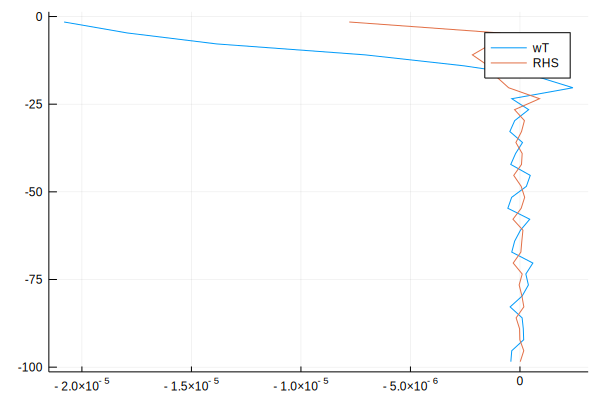

In [145]:
wT = dTdt_NN(Tₙ[:, 150]) |> Flux.data
RHS = new_NN(Tₙ[:, 150]) |> Flux.data

plot(wT[2:cr+1], z_cs, label="wT")
plot!(RHS[2:cr+1], z_cs, label="RHS")